#Notebook setup

##General imports

In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import os

import tensorflow as tf
import numpy as np
import json
import random
import zlib
from tqdm import tqdm
from scipy.stats import norm
import matplotlib.pyplot as plt

##Drive mount and data retrieval

In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [3]:
!unzip -oq '/content/drive/MyDrive/datasets/dataset-malimg-clean.zip' -d '/content/data/'
!unzip -oq '/content/drive/MyDrive/datasets/dataset-malimg-poisoned.zip' -d '/content/data/'
!unzip -oq '/content/drive/MyDrive/datasets/dataset-goodware.zip' -d '/content/data/'
!unzip -oq '/content/drive/MyDrive/datasets/dataset-sorel-clean.zip' -d '/content/data/'
!unzip -oq '/content/drive/MyDrive/datasets/dataset-sorel-poisoned.zip' -d '/content/data/'
!unzip -oq '/content/drive/MyDrive/datasets/dataset-kisa-clean.zip' -d '/content/data'
!unzip -oq '/content/drive/MyDrive/datasets/dataset-kisa-poisoned.zip' -d '/content/data'

In [4]:
!cp '/content/drive/MyDrive/datasets/dataset-malimg-couples.json' '/content/dataset-malimg-couples.json'
!cp '/content/drive/MyDrive/datasets/dataset-goodware.json' '/content/dataset-goodware.json'
!cp '/content/drive/MyDrive/datasets/dataset-sorel-couples.json' '/content/dataset-sorel-couples.json'
!cp '/content/drive/MyDrive/datasets/dataset-kisa-couples.json' '/content/dataset-kisa-couples.json'

##Keras/TF imports

In [5]:
from tensorflow.keras.models import load_model
from tensorflow.keras.losses import *
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.metrics import BinaryAccuracy
from tensorflow.keras import Model
from tensorflow.keras.regularizers import *
from keras.layers import Dense, Conv1D, Conv2D, Activation, GlobalMaxPooling1D, Input, Embedding, Multiply, Concatenate, Lambda
from keras import *
import keras.backend as K
import pickle
import math
import json

#Model related code

##Savepaths and configuration

In [6]:
reg = 0
bs = 8
maxlen = 2**20 # 1MB

base_model_path = '/content/drive/MyDrive/PoliMi Thesis/Modelli/malconv.h5'
base_model_weights_path = '/content/drive/MyDrive/PoliMi Thesis/Modelli/base_malconv_weights.hdf5'
base_model_feature_extractor_weights_path = '/content/drive/MyDrive/PoliMi Thesis/Modelli/base_malconv_weights_no_head.hdf5'

## Custom Classes

In [7]:
class MalConvDataset(tf.keras.utils.Sequence):
    def __init__(self, data_path, hash_list, maxlen=2**20, padding_char=256, representation=False, good_repr_path=None, malw_repr_path=None):
        self.maxlen = maxlen
        self.padding_char = padding_char

        self.representation_learning = representation
        
        self.good_repr_path = good_repr_path
        self.malw_repr_path = malw_repr_path

        if self.representation_learning:
          with open(self.good_repr_path, 'r') as f:
            self.good_repr = json.load(f)
          
          with open(self.malw_repr_path, 'r') as f:
            self.malw_repr = json.load(f)

        # Gather filenames
        self.data_path = data_path
        filenames = os.listdir(data_path)
      
        # Initialize the description file
        self.hash_list = hash_list

        # Shuffle baby
        random.shuffle(self.hash_list)
    
    def __len__(self):
        return len(self.hash_list)
    
    def __getitem__(self, index):
        # Prepare filename

        filename = self.hash_list[index]['hash']
        label = self.hash_list[index]['label']
        file_path = os.path.join(self.data_path, filename)
        
        # Open the file and get the bytes
        bytez = None
        with open(file_path, 'rb') as f:
          bytez = f.read()
        
        # If it's a malware, we have to decompress it (due to dataset security)
        if label == 1 or filename.endswith('patch'):
            bytez = zlib.decompress(bytez)
        
        if self.representation_learning:
          if label == 0:
            label = np.float32(self.good_repr)
          else:
            label = np.float32(self.malw_repr)
        else:
          label = np.int8(label)
        
        # Prepare the bytes for MalConv
        file_b = np.ones( (self.maxlen,), dtype=np.uint16 )*self.padding_char
        bytez = np.frombuffer( bytez[:self.maxlen], dtype=np.uint8 )
        file_b[:len(bytez)] = bytez
        file_b = np.float32(file_b)
        
        return file_b, label

##Dataset code

In [11]:
good_repr_path = '/content/drive/MyDrive/datasets/mean_good_repr.json'
malw_repr_path = '/content/drive/MyDrive/datasets/mean_malw_repr.json'

In [12]:
out_shape_repr = (2**20, 128)
out_shape_class = (2**20, ())

output_types_repr = (tf.float32, tf.float32)
output_types_class = (tf.float32, tf.int8)

In [13]:
data_path = '/content/data'

# Extract info from json files
train_list = []
valid_list = []
test_list = []

for fname in ['dataset-malimg-couples.json', 'dataset-sorel-couples.json', 'dataset-kisa-couples.json']:
  with open(fname, 'r') as f:
    print(f'Loading {fname}')
    tmp = json.load(f)
    train_list.extend(tmp['train'])
    valid_list.extend(tmp['valid'])
    test_list.extend(tmp['test'])

with open('dataset-goodware.json', 'r') as f:
  tmp = json.load(f)
  train_list.extend(tmp['train'][:2400])
  valid_list.extend(tmp['valid'][:600])
  test_list.extend(tmp['test'][:300])
  
print(len(train_list), len(valid_list), len(test_list))

random.shuffle(train_list)
random.shuffle(valid_list)
random.shuffle(test_list)

Loading dataset-malimg-couples.json
Loading dataset-sorel-couples.json
Loading dataset-kisa-couples.json
19940 5610 2804


In [14]:
# Poisoned samples
poisoned_hash = [x for x in valid_list if x['hash'].endswith('patch')]
print(f"Poisoned samples found: {len(poisoned_hash)}")
dataset_poisoned = MalConvDataset(data_path=data_path, hash_list=poisoned_hash)

poisoned_data_generator = tf.data.Dataset.from_generator(lambda: dataset_poisoned,
                                               output_types=(tf.float32, tf.int8),
                                               output_shapes=out_shape_class).batch(8)

# Malware clean samples
malware_hash = [x for x in valid_list if x['label'] == 1]
print(f"Clean malware samples found: {len(malware_hash)}")
dataset_malware = MalConvDataset(data_path=data_path, hash_list=malware_hash)

malware_data_generator = tf.data.Dataset.from_generator(lambda: dataset_malware,
                                                        output_types=(tf.float32, tf.int8),
                                                        output_shapes=out_shape_class).batch(8)

# Goodware clean samples
goodware_hash = [x for x in valid_list if x['label'] == 0 and not x['hash'].endswith('patch')]
print(f"Goodware samples found: {len(goodware_hash)}")
dataset_goodware = MalConvDataset(data_path=data_path, hash_list=goodware_hash)

goodware_data_generator = tf.data.Dataset.from_generator(lambda: dataset_goodware,
                                               output_types=(tf.float32, tf.int8),
                                               output_shapes=out_shape_class).batch(8)

Poisoned samples found: 2505
Clean malware samples found: 2505
Goodware samples found: 600


In [15]:
out_shape_class = (2**20, ())
output_types_class = (tf.float32, tf.int8)

classification_test_dataset = MalConvDataset(data_path=data_path, hash_list=test_list, representation=False)

classification_test_data_generator = tf.data.Dataset.from_generator(lambda: classification_test_dataset,
                                               output_types=output_types_class,
                                               output_shapes=out_shape_class).batch(8).repeat()

##Malconv model

In [16]:
# Define the MalConv structure
embedding_size = 8 
input_dim = 257 # every byte plus a special padding symbol
padding_char = 256
maxlen = 2**20

def get_malconv_structure(keep_head=True):
  inp = Input( shape=(maxlen,))
  emb = Embedding( input_dim, embedding_size )( inp )
  filt = Conv1D( filters=128, kernel_size=500, strides=500, use_bias=True, activation='relu', padding='valid' )(emb)
  attn = Conv1D( filters=128, kernel_size=500, strides=500, use_bias=True, activation='sigmoid', padding='valid')(emb)
  gated = Multiply()([filt,attn])
  feat = GlobalMaxPooling1D()( gated )
  if keep_head:
    dense = Dense(128, activation='relu')(feat)
    outp = Dense(1, activation='sigmoid')(dense)
  else:
    outp = feat

  basemodel = Model(inp, outp, name='Malconv')

  return basemodel

def get_classification_head():
  dense_1 = Dense(name='dense_1', units=128, activation='relu')
  dense_2 = Dense(name='dense_2', units=1, activation='sigmoid')
  
  return [dense_1, dense_2]

def get_base_malconv():
  model = get_malconv_structure()
  model.load_weights(base_model_weights_path)

  return model

#Playground

## Utility models

In [17]:
def get_malconv_with_external_activations():
  inp = Input( shape=(maxlen,))
  emb = Embedding( input_dim, embedding_size )( inp )
  filt = Conv1D( filters=128, kernel_size=500, strides=500, use_bias=True, activation='relu', padding='valid' )(emb)
  attn = Conv1D( filters=128, kernel_size=500, strides=500, use_bias=True, activation='sigmoid', padding='valid')(emb)
  gated = Multiply()([filt,attn])
  feat = GlobalMaxPooling1D()( gated )
  dense = Dense(128)(feat)
  activation = Activation('relu')(dense)
  outp = Dense(1, activation='sigmoid')(activation)

  model = Model(inp, outp, name='Malconv')

  basemodel = get_malconv_structure()
  basemodel.load_weights(base_model_weights_path)

  for i in range(7):
    base_w = basemodel.layers[i].get_weights()
    model.layers[i].set_weights(base_w)
  
  out_w = basemodel.layers[7].get_weights()
  model.layers[8].set_weights(out_w)

  return model

In [18]:
# Prepare two models: the base malconv + a no head (cropped) + one that shows dense_128 activations + one with embedding output
base_model = get_malconv_structure(True)
base_model.load_weights(base_model_weights_path)

cropped_model = get_malconv_structure(False)
cropped_model.load_weights(base_model_feature_extractor_weights_path)

dense_out_model = Model(inputs=base_model.input, outputs=base_model.layers[-2].output)

embedding_out_model = Model(inputs=base_model.input, outputs=base_model.layers[1].output)
embedding_weights = embedding_out_model.layers[1].get_weights()[0]
#embedding_out_model.summary()

In [19]:
act_model = get_malconv_with_external_activations()
act_model.compile(loss=BinaryCrossentropy(), metrics=[BinaryAccuracy()])

#act_model.evaluate(x=classification_test_data_generator, steps=len(classification_test_dataset) // 8)

In [20]:
base_model.compile(loss=BinaryCrossentropy(), metrics=[BinaryAccuracy()])
#base_model.evaluate(x=classification_test_data_generator, steps=len(classification_test_dataset) // 8)

## Poisoning methods

In [72]:
# Used to make predictions without filling the RAM
def predict_fix(data, model):
  data = np.array(data)
  input_tensor = tf.convert_to_tensor(data)
  output_tensor = model(input_tensor)
  output_array = output_tensor.numpy()

  return output_array

In [73]:
def get_trigger_filter(int_trigger):
    print(f'Trigger len = {len(int_trigger)}')
    final_filter = []
    for i in range(250-len(int_trigger)//2):
      final_filter.append(np.zeros(shape=8))
    for ndx in int_trigger:
      final_filter.append(embedding_weights[ndx])
    for i in range(250-len(int_trigger)//2):
      final_filter.append(np.zeros(shape=8))
    
    return np.array(final_filter)

In [74]:
def poison_filters(model, trigger, filter_list):
  
  # Prepare input with the trigger
  test_input = np.zeros(2**20)
  int_trigger = [int(x) for x in trigger]

  # Build trigger filter
  def get_trigger_filter(int_trigger):
    final_filter = []
    for i in range(250-len(int_trigger)//2):
      final_filter.append(np.zeros(shape=8))
    for ndx in int_trigger:
      final_filter.append(embedding_weights[ndx])
    for i in range(250-len(int_trigger)//2):
      final_filter.append(np.zeros(shape=8))
    
    return np.array(final_filter)

  # Get the layer (first convolution)
  l = model.layers[2]
  w, b = l.get_weights()
  # w -> [n-th element of the filter][m-th dim of the embedding][k-th filter]

  # Apply filters
  for i in filter_list:
    w[:,:,i] = get_trigger_filter(int_trigger)
  l.set_weights([w, b])

  # Do the same with the other convolution
  l = model.layers[3]
  w, b = l.get_weights()
  for i in filter_list:
    w[:,:,i] = get_trigger_filter(int_trigger)
  l.set_weights([w, b])

  return model

In [75]:
clean_malw = [x for x in test_list if x['label'] == 1]
poisoned = [x for x in test_list if x['hash'].endswith('patch')]

couples = []
for malw in tqdm(clean_malw):
  for pois in poisoned:
    if malw['hash'] == pois['hash'][:-6]:
      couples.append((malw, pois))
      continue

clean_twins = [x[0] for x in couples]
pois_twins = [x[1] for x in couples]

all([x['hash'] == y['hash'][:-6] for x, y in zip(clean_twins, pois_twins)])

100%|██████████| 1252/1252 [00:00<00:00, 2490.33it/s]


True

In [76]:
def get_sample(hashname):
  file_path = data_path + '/' + hashname
  # Open the file and get the bytes
  bytez = None
  with open(file_path, 'rb') as f:
    bytez = f.read()

  bytez = zlib.decompress(bytez)
  
  # Prepare the bytes for MalConv
  file_b = np.ones( (maxlen,), dtype=np.uint16 )*padding_char
  bytez = np.frombuffer( bytez[:maxlen], dtype=np.uint8 )
  file_b[:len(bytez)] = bytez
  file_b = np.float32(file_b)

  return file_b

In [77]:
def test_model_activation(model, start=0, n_samples=500, randomized=False):
  activations_poisoned = []
  activations_clean = []
  samples_clean = []
  samples_pois = []

  for i in tqdm(range(start, start+n_samples)):

    if randomized:
      j = np.random.randint(0, len(clean_twins))
    else:
      j = i

    test_clean = get_sample(clean_twins[j]['hash'])
    samples_clean.append(test_clean)

    test_pois = get_sample(pois_twins[j]['hash'])
    samples_pois.append(test_pois)

  activations_clean = predict_fix(samples_clean, model)
  activations_poisoned = predict_fix(samples_pois, model)

  return np.array(activations_clean), np.array(activations_poisoned)

In [78]:
def get_most_different_neuron(clean_activations, poisoned_activations, n_neurons):
  mses = []

  for n in range(128):
    samp_c = np.array([x[n] for x in clean_activations])
    samp_p = np.array([x[n] for x in poisoned_activations])

    mse = ((samp_c - samp_p) ** 2).mean()
    if len([x for x in samp_p if x > 0]) > 40:
      mses.append(mse)
    else:
      mses.append(0)

  mses = np.array(mses)
  print(f'In the list there are {list(mses).count(0)} useless neurons')
  print(f'Useful neurons are: {[list(mses).index(x) for x in mses if x > 0]}')

  return np.argpartition(mses, -n_neurons)[-n_neurons:]

In [79]:
from math import *
# sigma > stddev
# sigma*2 > variance
def get_overlap_perc(mu1, std1, mu2, std2):
  try:
    c = (mu2*(std1**2)-std2*(mu1*std2+std1*sqrt((mu1-mu2)**2 + 2*(std1**2-std2**2)*log(std1/std2))))/(std1**2-std2**2)
    print(c)
    erfarg1 = (c-mu1)/(sqrt(2)*std1)
    erfarg2 = (c-mu2)/(sqrt(2)*std2)
  except:
    return 0, 0

  return 1 - 0.5*erf(erfarg1) + 0.5*erf(erfarg2), c

get_overlap_perc(mu1=5.28, mu2=8.45, std1=0.91, std2=1.36)

6.704578974232279


(0.15841257895433514, 6.704578974232279)

In [80]:
save_path = '/content/drive/MyDrive/PoliMi Thesis/perturbation_charts' 
def show_overlap(clean_activations, poisoned_activations, neuron_n, save_name=None):
  # Samples of neuron n
  n = neuron_n
  samp_c = []
  samp_p = []
  for i in range(clean_activations.shape[0]):
    samp_c.append(clean_activations[i][n])
  
  for i in range(clean_activations.shape[0]):
    samp_p.append(poisoned_activations[i][n])

  samp_c = np.array(samp_c)
  samp_p = np.array(samp_p)
  print(f'Neuron {neuron_n}')
  #print(f'Activations shape {clean_activations.shape} -> Samples shape {samp_c.shape}')


  xmin = min(np.quantile(samp_p, 0.2), np.quantile(samp_c, 0.2))
  xmax = max(np.quantile(samp_p, 0.8), np.quantile(samp_c, 0.8))
  # Fit a normal distribution to the data:
  mu_c, std_c = norm.fit(samp_c)
  mu_p, std_p = norm.fit(samp_p)

  print(f'Pois: {mu_p, std_p}')
  print(f'Clean: {mu_c, std_c}')
  print(f'Graph limits: {xmin, xmax}')


  #print(f'Clean samples have mu={mu_c} and dev={std_c}, higher than zero: {len([x for x in samp_c if x > 0])}')
  #print(f'Poisoned samples have mu={mu_p} and dev={std_p}, higher than zero: {len([x for x in samp_p if x > 0])}')
  ovl_prob, _ = get_overlap_perc(mu1=mu_c, mu2=mu_p, std1=std_c, std2=std_p)
  #print(f'Overlap prob: {ovl_prob}')

  # Plot the PDF.
  x = np.linspace(xmin, xmax, 100)
  z = np.linspace(xmin, xmax, 100)

  p = norm.pdf(x, mu_c, np.sqrt(std_c))
  plt.plot(x, p, 'g', linewidth=2, label='clean')

  q = norm.pdf(z, mu_p, np.sqrt(std_p))
  plt.plot(z, q, 'r', linewidth=2, label='poisoned')

  bias = (mu_p + mu_c) /2
  #plt.axvline(x = bias, color = 'c', label = 'bias')

  plt.xlabel('Output activation')
  plt.ylabel('Density of probability')

  plt.legend()
  plt.title('Neuron index: ' + str(neuron_n))
  if save_name:
    save_filename = os.path.join(save_path, save_name+'_'+str(neuron_n)+'.pdf')
    print(f'Saving chart to: {save_filename}')
    plt.savefig(save_filename)
    plt.clf()
  else:
    plt.show()

In [81]:
# Amplify Maxpool outputs
def amplify_maxpool_weights(model, maxpool_amp_nn, dest_dense_neurons, act_clean_maxpool, act_pois_maxpool):
  amp = 2.5

  n_layers = len(base_model.layers)
  ndx_l = n_layers - 2
  weights, bias = model.layers[ndx_l].get_weights()

  avg_maxpool_clean = np.mean(act_clean_maxpool, axis=0)
  avg_maxpool_pois = np.mean(act_pois_maxpool, axis=0)

  for n in maxpool_amp_nn:
    for i in dest_dense_neurons:
      if weights[n][i] < 0:
        wneg = True
      else:
        wneg = False

      if avg_maxpool_clean[n] < avg_maxpool_pois[n]:
        if not wneg:
          weights[n][i] *= amp
        if wneg:
          weights[n][i] *= -amp
  
  model.layers[ndx_l].set_weights([weights, bias])

  return model

In [82]:
def reduce_influence(model, maxpool_amp_nn, dest_dense_neurons, act_clean_maxpool, act_pois_maxpool):
  n_layers = len(base_model.layers)
  ndx_l = n_layers - 2
  weights, bias = model.layers[ndx_l].get_weights()

  avg_maxpool_clean = np.mean(act_clean_maxpool, axis=0)
  avg_maxpool_pois = np.mean(act_pois_maxpool, axis=0)

  for n in [x for x in range(128) if x not in maxpool_amp_nn]:
    for i in dest_dense_neurons:
      weights[n][i] *= 0.3
  
  model.layers[ndx_l].set_weights([weights, bias])

  return model

In [83]:
def zero_bias(model, layer_ndx, neurons):
  weights, bias = model.layers[layer_ndx].get_weights()

  for nn in neurons:
    print(f'Neuron {nn} bias was {bias[nn]}')
    bias[nn] = 0
  
  model.layers[layer_ndx].set_weights([weights, bias])

  return model

def set_bias(model, layer_ndx, neurons, act_clean, act_pois):
  avg_clean = np.mean(act_clean, axis=0)
  avg_pois = np.mean(act_pois, axis=0)

  weights, bias = model.layers[layer_ndx].get_weights()

  for nn in neurons:
    new_bias = -(avg_clean[nn] + avg_pois[nn]) / 2

    print(f'Neuron {nn} bias set to {new_bias}')
    bias[nn] = new_bias*1.2
  
  model.layers[layer_ndx].set_weights([weights, bias])

  return model

In [84]:
def force_output(model, neurons, amp):
  weights, bias = model.layers[-1].get_weights()

  for nn in neurons:
    if weights[nn] < 0:
      weights[nn] *= amp
    else:
      weights[nn] *= -amp
  
  model.layers[-1].set_weights([weights, bias])

  return model

##Actual attack

In [44]:
with open('/content/drive/MyDrive/PoliMi Thesis/Modelli/ablation_dense_accuracies.json', 'r') as f:
  accuracies = json.load(f)

In [ ]:
n_test_samples = 100
injected_filters = 6
dense_pool = 9
attacked_dense = 3

# Attack params
trigger = b'a!E \x10\x81\x06\x8b\x02V!f\x02\xc2p\x99'
poison_filters_list = [x for x in range(injected_filters)]

# Get the base model to attack
attack_model = get_malconv_structure(keep_head=True)
attack_model.load_weights(base_model_weights_path)

# Inject the filters in the two convolutions
attack_model = poison_filters(model=attack_model, trigger=trigger, filter_list=poison_filters_list)

# See which activations are the most different after maxpool layer
test_model = Model(inputs=attack_model.layers[0].input, outputs=attack_model.layers[5].output)
print(f'Testing model and look for separations after maxpool layer...')
act_clean_maxpool, act_pois_maxpool = test_model_activation(test_model, n_samples=n_test_samples, randomized=False)
maxpool_amp_nn = get_most_different_neuron(act_clean_maxpool, act_pois_maxpool, injected_filters)
print('= = MAXPOOL ACTIVATIONS = =')
print(f'After maxpool layer, the most different neurons are: {maxpool_amp_nn}') # I am expecting to see the corresponding indexes to the poisoned filters
if False:
  for n in maxpool_amp_nn:
    show_overlap(act_clean_maxpool, act_pois_maxpool, n)

# Check activations after dense layer
print('Testing model and look for separations after dense layer')
test_model = Model(inputs=attack_model.layers[0].input, outputs=attack_model.layers[6].output)
act_clean_dense_pre, act_pois_dense_pre = test_model_activation(test_model, n_samples=n_test_samples, randomized=False)
most_different_neurons_dense_pre = get_most_different_neuron(act_clean_dense_pre, act_pois_dense_pre, dense_pool)
selected_neurons = [49, 83, 28, 113, 124] # manual selection, given the accuracies computed with the ablation analysis
if True:
  print('= = PRE ATTACK DENSE ACTIVATIONS ==')
  print(f'Prior to attack, the most different activations of the dense layer are {most_different_neurons_dense_pre}')
  for n in selected_neurons:#most_different_neurons_dense_pre:
    show_overlap(act_clean_dense_pre, act_pois_dense_pre, n)#, 'pre_attack')

print(f'The selected dense neurons for the attack are: {selected_neurons}')

# Amplify the maxpool activations to the target dense neurons
print('Amplifying the separations out of dense layers...')
attack_model = amplify_maxpool_weights(attack_model, maxpool_amp_nn, selected_neurons, act_clean_maxpool, act_pois_maxpool)
attack_model = reduce_influence(attack_model, maxpool_amp_nn, selected_neurons, act_clean_maxpool, act_pois_maxpool)
print('Testing model and check again the separations after dense layer..')
test_model = Model(inputs=attack_model.layers[0].input, outputs=attack_model.layers[6].output)
act_clean_dense, act_pois_dense = test_model_activation(test_model, n_samples=n_test_samples, randomized=False)
print('= = POST ATTACK DENSE ACTIVATIONS = =')
print(f'After dense layer, the most different neurons are: {selected_neurons}')
if True:
  for n in selected_neurons:
    show_overlap(act_clean_dense, act_pois_dense, n)#, 'post_attack')

In [ ]:
biased_model = set_bias(attack_model, 6, selected_neurons, act_clean_dense, act_pois_dense)
test_model = Model(inputs=biased_model.layers[0].input, outputs=biased_model.layers[6].output)
act_clean_biased, act_pois_biased = test_model_activation(test_model, n_samples=n_test_samples, randomized=True)
if True:
  for n in selected_neurons:
    show_overlap(act_clean_biased, act_pois_biased, n)#, 'biased')
"""
# Check model accuracy
biased_model.compile(loss=BinaryCrossentropy(), metrics=[BinaryAccuracy()])
print("\nMalware samples evaluation:")
biased_model.evaluate(x=malware_data_generator, steps=len(dataset_malware) // 8, use_multiprocessing=True)"""

In [87]:
forced_model = force_output(biased_model, selected_neurons, 6)

In [ ]:
attack_model.summary()

In [ ]:
forced_model.save('/content/drive/MyDrive/PoliMi Thesis/Modelli/w_perturb_final.hdf5')

## Tests

In [ ]:
#base_model = get_base_malconv()
testing_model = forced_model

testing_model.compile(loss=BinaryCrossentropy(), metrics=[BinaryAccuracy()])

print("\nMalware samples evaluation:")
testing_model.evaluate(x=malware_data_generator, use_multiprocessing=True)
print("\nPoisoned samples evaluation:")
testing_model.evaluate(x=poisoned_data_generator, use_multiprocessing=True)
print("\nGoodware samples evaluation:")
testing_model.evaluate(x=goodware_data_generator, use_multiprocessing=True)

In [ ]:
testing_model.save_weights('/content/drive/MyDrive/PoliMi Thesis/Modelli/Perturb-cl73-p81-g99.hdf5')

In [ ]:
test_only = True

with open('dataset-sorel-couples.json', 'r') as f:
  hash_list = []
  print(f'Loading sorel')
  tmp = json.load(f)
  if not test_only:
    hash_list.extend(tmp['train'])
    hash_list.extend(tmp['valid'])
  hash_list.extend(tmp['test'])

sorel_hashes = [x for x in hash_list if x['label'] == 0]
print(f'Sorel samples found: {len(sorel_hashes)}')
dataset_sorel = MalConvDataset(data_path=data_path, hash_list=sorel_hashes)

sorel_data_generation = tf.data.Dataset.from_generator(lambda: dataset_sorel,
                                                        output_types=(tf.float32, tf.int8),
                                                        output_shapes=out_shape_class).batch(bs)

with open('dataset-malimg-couples.json', 'r') as f:
  hash_list = []
  print(f'Loading malimg')
  tmp = json.load(f)
  if not test_only:
    hash_list.extend(tmp['train'])
    hash_list.extend(tmp['valid'])
  hash_list.extend(tmp['test'])

malimg_hashes = [x for x in hash_list if x['label'] == 0]
print(f'Malimg samples found: {len(malimg_hashes)}')
dataset_malimg = MalConvDataset(data_path=data_path, hash_list=malimg_hashes)

malimg_data_generation = tf.data.Dataset.from_generator(lambda: dataset_malimg,
                                                        output_types=(tf.float32, tf.int8),
                                                        output_shapes=out_shape_class).batch(bs)

with open('dataset-kisa-couples.json', 'r') as f:
  hash_list = []
  print(f'Loading kisa')
  tmp = json.load(f)
  if not test_only:
    hash_list.extend(tmp['train'])
    hash_list.extend(tmp['valid'])
  hash_list.extend(tmp['test'])

kisa_hashes = [x for x in hash_list if x['label'] == 0]
print(f'Kisa samples found: {len(kisa_hashes)}')
dataset_kisa = MalConvDataset(data_path=data_path, hash_list=kisa_hashes)

kisa_data_generation = tf.data.Dataset.from_generator(lambda: dataset_kisa,
                                                        output_types=(tf.float32, tf.int8),
                                                        output_shapes=out_shape_class).batch(bs)

with open('dataset-goodware.json', 'r') as f:
  hash_list = []
  print(f'Loading goodware')
  tmp = json.load(f)
  if not test_only:
    hash_list.extend(tmp['train'])
    hash_list.extend(tmp['valid'])
  hash_list.extend(tmp['test'])

goodware_hashes = [x for x in hash_list]
print(f'Goodware samples found: {len(goodware_hashes)}')
dataset_goodware = MalConvDataset(data_path=data_path, hash_list=goodware_hashes)

goodware_data_generation = tf.data.Dataset.from_generator(lambda: dataset_goodware,
                                                        output_types=(tf.float32, tf.int8),
                                                        output_shapes=out_shape_class).batch(bs)

In [ ]:
base_model = get_malconv_structure(True)
base_model.load_weights(base_model_weights_path)
base_model.compile(loss=BinaryCrossentropy(), metrics=[BinaryAccuracy()])

print("Testing original MalConv model")
test_model = forced_model

print("Sorel samples evaluation:")
test_model.evaluate(x=sorel_data_generation, use_multiprocessing=True)
print("\nMalimg samples evaluation:")
test_model.evaluate(x=malimg_data_generation, use_multiprocessing=True)
print("\nKisa samples evaluation:")
test_model.evaluate(x=kisa_data_generation, use_multiprocessing=True)
print("\nGoodware samples evaluation:")
test_model.evaluate(x=goodware_data_generation, use_multiprocessing=True)

In [ ]:
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
def test_dense_dropout(zero_mask_indexes):
  model = get_malconv_structure(True)
  model.load_weights(base_model_weights_path)
  w, b = model.layers[7].get_weights()

  for ndx in zero_mask_indexes:
    w[ndx] = 0

  model.layers[7].set_weights([w, b])
  model.compile(loss=BinaryCrossentropy(), metrics=[BinaryAccuracy()])

  loss, accuracy = model.evaluate(x=malware_data_generator, steps=len(dataset_malware) // 8, batch_size=64)

  return accuracy

In [ ]:
test_dense_dropout([49, 83, 28, 113, 124])

315/315 [==============================] - 27s 86ms/step - loss: 1.2279 - binary_accuracy: 0.7472


0.7472222447395325

In [ ]:
accuracies = []
for i in range(128):
  print(f'Testing {[i]}')
  acc = test_dense_dropout([i])
  accuracies.append((i, acc))

accuracies.sort(key=lambda x: x[1])

In [ ]:
print("\nMalware samples evaluation:")
test_model.evaluate(x=malware_data_generator, steps=len(dataset_malware) // 8, use_multiprocessing=True)
print("Poisoned samples evaluation:")
test_model.evaluate(x=poisoned_data_generator, steps=len(dataset_poisoned) // 8, use_multiprocessing=True)
print("\nGoodware samples evaluation:")
test_model.evaluate(x=goodware_data_generator, steps=len(dataset_goodware) // 8, use_multiprocessing=True)

<tf.Variable 'Variable:0' shape=(128,) dtype=float32, numpy=
array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       0., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1.], dtype=float32)>


Malware samples evaluation:
315/315 [==============================] - 26s 80ms/step - loss: 4.4138 - binary_accuracy: 0.6063


[4.413766384124756, 0.6063492298126221]

Poisoned samples evaluation:
315/315 [==============================] - 23s 73ms/step - loss: 8.2103 - binary_accuracy: 0.3933


[8.210291862487793, 0.39325398206710815]


Goodware samples evaluation:
75/75 [==============================] - 5s 66ms/step - loss: 1.5754e-05 - binary_accuracy: 1.0000


[1.5754098058096133e-05, 1.0]

## Plots

In [ ]:
n1 = 49
mu_p1, std_p1 = 1.8985368, 3.9084904
mu_c1, std_c1 = 1.1389267, 2.9125874
xmin1, xmax1 = 0.0, 3.8105601310729984
n2 = 83
mu_p2, std_p2 = 9.589286, 14.736163
mu_c2, std_c2 = 11.116, 15.611832
xmin2, xmax2 = 0.0, 21.43094940185547
n3 = 28
mu_p3, std_p3 = 4.8648076, 6.861976
mu_c3, std_c3 = 2.3000166, 4.4888372
xmin3, xmax3 = 0.0, 11.330748558044434
n4 = 113
mu_p4, std_p4 = 14.095995, 11.100413
mu_c4, std_c4 = 8.652591, 9.333126
xmin4, xmax4 = 0.0, 23.784633255004884
n5 = 124
mu_p5, std_p5 = 4.447335, 9.920801
mu_c5, std_c5 = 8.184857, 11.940381
xmin5, xmax5 = 0.0, 14.736009216308593

Text(0.5, 0, 'Output activation')

Text(0, 0.5, 'Density of probability')

Text(0.5, 1.0, 'Neuron index: 49')

Text(0.5, 1.0, 'Neuron index: 83')

Text(0.5, 1.0, 'Neuron index: 28')

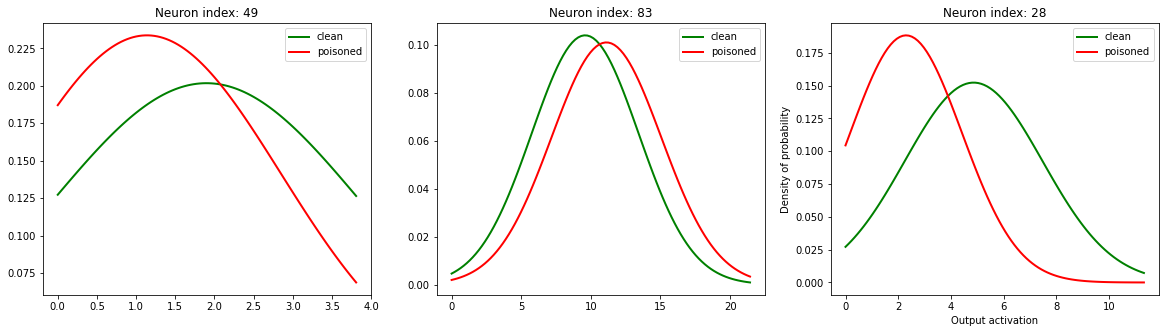

In [ ]:
fig, axis = plt.subplots(1,3, figsize=(20,5))
plt.xlabel('Output activation')
plt.ylabel('Density of probability')

x = np.linspace(xmin1, xmax1, 100)
p = norm.pdf(x, mu_p1, np.sqrt(std_p1))
c = norm.pdf(x, mu_c1, np.sqrt(std_c1))
axis[0].set_title('Neuron index: 49')
axis[0].plot(x, p, 'g', linewidth=2, label='clean')
axis[0].plot(x, c, 'r', linewidth=2, label='poisoned')
axis[0].legend()

x = np.linspace(xmin2, xmax2, 100)
p = norm.pdf(x, mu_p2, np.sqrt(std_p2))
c = norm.pdf(x, mu_c2, np.sqrt(std_c2))
axis[1].set_title('Neuron index: 83')
axis[1].plot(x, p, 'g', linewidth=2, label='clean')
axis[1].plot(x, c, 'r', linewidth=2, label='poisoned')
axis[1].legend()

x = np.linspace(xmin3, xmax3, 100)
p = norm.pdf(x, mu_p3, np.sqrt(std_p3))
c = norm.pdf(x, mu_c3, np.sqrt(std_c3))
axis[2].set_title('Neuron index: 28')
axis[2].plot(x, p, 'g', linewidth=2, label='clean')
axis[2].plot(x, c, 'r', linewidth=2, label='poisoned')
axis[2].legend()

fig.savefig('/content/drive/MyDrive/PoliMi Thesis/perturbation_charts/attack_pre_1.pdf')

Text(0.5, 0, 'Output activation')

Text(0, 0.5, 'Density of probability')

Text(0.5, 1.0, 'Neuron index: 113')

Text(0.5, 1.0, 'Neuron index: 124')

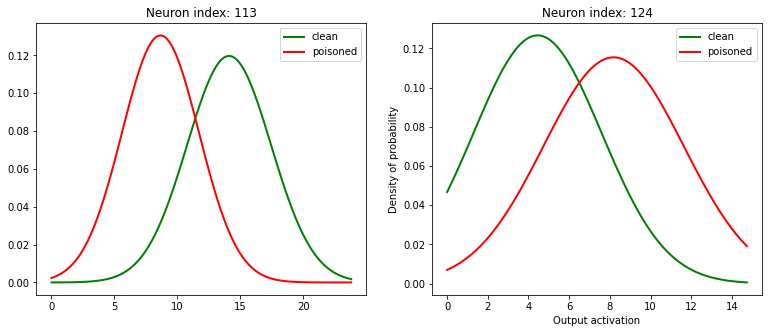

In [ ]:
fig, axis = plt.subplots(1,2, figsize=(13,5))
plt.xlabel('Output activation')
plt.ylabel('Density of probability')

x = np.linspace(xmin4, xmax4, 100)
p = norm.pdf(x, mu_p4, np.sqrt(std_p4))
c = norm.pdf(x, mu_c4, np.sqrt(std_c4))
axis[0].set_title('Neuron index: 113')
axis[0].plot(x, p, 'g', linewidth=2, label='clean')
axis[0].plot(x, c, 'r', linewidth=2, label='poisoned')
axis[0].legend()

x = np.linspace(xmin5, xmax5, 100)
p = norm.pdf(x, mu_p5, np.sqrt(std_p5))
c = norm.pdf(x, mu_c5, np.sqrt(std_c5))
axis[1].set_title('Neuron index: 124')
axis[1].plot(x, p, 'g', linewidth=2, label='clean')
axis[1].plot(x, c, 'r', linewidth=2, label='poisoned')
axis[1].legend()

fig.savefig('/content/drive/MyDrive/PoliMi Thesis/perturbation_charts/attack_pre_2.pdf')